### **4. Customer segmentation**

In this section, we will segment our customers in order to guide our commercial activity. Knowing what the customers who belong to each group are like, will help us a lot when defining our marketing for the future. The phases we will work on include:

**4.1 Construction and last cleaning:** Creation of new features, creation of the df_last_partition that we will use for segmentation and last cleaning of the df.  
**4.2 Clustering using k-means:**     
**4.3 Cluster interpretation:**    
**4.4 Clients file:**    



Libraries:

In [1]:
# Data analysis and wrangling
import numpy as np
import pandas as pd
import datetime
import time
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OrdinalEncoder,StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

# Machine learning
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics

Acquire data from the last notebook:

In [2]:
df = pd.read_csv('data2_easymoney.csv')

A small data type fix

In [3]:
df["pk_partition"]=pd.to_datetime(df["pk_partition"], format='%Y-%m-%d')
df["entry_date"]=pd.to_datetime(df["entry_date"], format='%Y-%m-%d')

#### **4.1 Construction and last cleaning**

##### **Creating new features**

Later we will create a df with only the data from the last month to make the Customer Segmentation.

However, keeping only the data from the last month has disadvantages, for example we are leaving a lot of information from past months unused. We will create some features that collect information about the previous months and in this way we can optimize the construction of the clusters.

* Registration time: time from registration to last partition
* Total registrations: total product registrations
* Total cancellations: total product cancellations
* Total revenues: Easymoney revenues from contracted products
* Average duration of products

**Registration time**  

Knowing how long the client has been discharged can provide us with useful information.  
Last date in the records are '2019-05-28'

In [4]:
df['loyalty'] = (pd.to_datetime('2019-05-28') - df['entry_date']).dt.days

**Total registrations and total cancellations**

We will calculate how manny times a customer has registered and unsubscribed for each product. Then will see the total registrations and total cancellations per customer.   

First of all we load the list of products from the Preprocessing section

In [5]:
prod_columns = ['short_term_deposit', 'loans', 'mortgage',
       'funds', 'securities', 'long_term_deposit', 'credit_card', 'payroll',
       'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
       'em_account_p', 'em_account']

We create a RegistrationsCancellations function, which will return us how many registrations and cancellations we have per customer and per product.

In [6]:
def RegistrationsCancellations(df, products):
    
    for i in products:
        previous_month = i + "_previous_month"
        difference = i + "_dif"
        dicc_reg = i + "_dicc_reg"
        dicc_canc = i + "_dicc_canc"
        registrations = i + "_registrations"
        cancellations = i + "_cancellations"
    
        #calculation of the contracted product for the previus month and the difference between both months.
        df[previous_month] = df.groupby('pk_cid')[i].shift(1)
        df[difference] = df[i] - df[previous_month]

        # REGISTRATIONS: creation of a diccionary in which -->
        # keys = pk_cid  ;  values = number of times difference is equal to 1
        dicc_reg = (df.loc[df[difference] == 1].groupby('pk_cid').size()).to_dict()
        df[registrations] = df['pk_cid'].map(dicc_reg).fillna(0).astype(int)
        
        # CANCELLATIONS: creation of a diccionary in which -->
        # keys = pk_cid  ;  values = number of times difference is equal to -1
        dicc_canc = (df.loc[df[difference] == -1].groupby('pk_cid').size()).to_dict()
        df[cancellations] = df['pk_cid'].map(dicc_canc).fillna(0).astype(int)

        #remove irrelevant columns
        df = df.drop([previous_month,difference], axis = 1)
        
        
    return df
    

In [7]:
df = RegistrationsCancellations(df, prod_columns)

Example: The client with 'pk_cid' == 1052217 we see that he has up to 4 registrations for the debit_card product and 3 cancellations. Let's see how the final df of these columns would look.

In [8]:
df.loc[df['pk_cid'] == 1052217, ['pk_partition', 'debit_card','debit_card_registrations', 'debit_card_cancellations'] ]

,pk_partition,debit_card,debit_card_registrations,debit_card_cancellations
884,2018-01-28,0,4,3
474283,2018-02-28,1,4,3
694896,2018-03-28,1,4,3
965738,2018-04-28,1,4,3
981599,2018-05-28,0,4,3
1257703,2018-06-28,0,4,3
1581909,2018-07-28,1,4,3
2046404,2018-08-28,0,4,3
2327229,2018-09-28,0,4,3
2672230,2018-10-28,1,4,3


Now we have everything necessary to calculate for each client how many total **Registrations and Cancellations** they have. We create a function, which will return us how many total registrations and total cancellations we have per customer.

In [9]:
def TotalRegistrationsCancellations(df):
    
    df['Registrations'] = df.filter(like='registration').sum(axis = 1)
    df['Cancellations'] = df.filter(like='cancellation').sum(axis = 1)
    
    return df

In [10]:
df = TotalRegistrationsCancellations(df)

In [11]:
df[['pk_cid','Registrations','Cancellations']].sample(10)

,pk_cid,Registrations,Cancellations
1448718,1269921,0,0
1981255,1347959,0,0
333282,1318853,0,0
1110090,1362408,7,7
748271,1204994,0,0
771609,1156690,0,0
2792032,1489519,1,0
4994620,1205557,1,1
5660637,1480956,0,0
5654350,1509583,0,0


**Total revenues**

Easymoney gives us the following information about the income it receives from product registrations:  
* €10 for each account product sold
* €40 for each savings product sold
* €60 for each financing product sold   


First of all we load the list of the different products from the Preprocessing section

In [12]:
account_prod = ['payroll', 'payroll_account', 'emc_account', 'em_account_p', 'em_account', 
                'debit_card']
financing_prod = ['loans', 'mortgage', 'credit_card']
saving_prod = ['short_term_deposit', 'funds', 'securities', 'long_term_deposit',
               'pension_plan' ]

We create the feature revenue, multiplying each registration by its corresponding income, depending on what type of product it is:

In [13]:
df['total_revenue'] = df['payroll_registrations']*10 + df['payroll_account_registrations']*10 + df['emc_account_registrations']*10 + df['em_account_p_registrations']*10 + df['em_account_registrations']*10 + df['debit_card_registrations']*10 + df['loans_registrations']*60 + df['mortgage_registrations']*60 + df['credit_card_registrations']*60 + df['short_term_deposit_registrations']*40 + df['funds_registrations']*40 + df['securities_registrations']*40 + df['long_term_deposit_registrations']*40 + df['pension_plan_registrations']*40

We see how total_feature has values from 0 to 550 at most.
We also observe that the vast majority of clients have a 0 in this variable, that is, we can already see that there are many clients who have registered on the platform, but who have never contracted a product.

In [14]:
df['total_revenue'].unique()

array([ 20,   0,  50,  10,  40,  60,  70, 200, 130, 190, 110,  80, 160,
       120, 100,  90,  30, 150, 260, 230, 220, 140, 170, 330, 180, 210,
       240, 310, 280, 250, 290, 300, 270, 390, 410, 320, 380, 360, 370,
       420, 450, 400, 440, 340, 350, 430, 460, 550, 470, 500, 490])

In [15]:
df['total_revenue'].value_counts().head(10)

total_revenue
0      4704895
10      463407
20      156704
60       96041
40       72142
30       71543
50       67088
70       66577
80       36116
120      35947
Name: count, dtype: int64

**Average duration of products**

We want to calculate how much average time each customer has products in their portfolio.

To do this, we first calculate the mean of each product separately (df.groupby('pk_cid')[prod_columns].mean()). Here, for example, if the average 'em_account' is 0.5, it means that half of the time this customer has been registered on the platform he had this product contracted. Then we do the mean() again to find the total average of all products per customer.



In [16]:
average_customer = (df.groupby('pk_cid')[prod_columns].mean()).mean(axis=1)

In [17]:
df['average_time_products'] = df['pk_cid'].map(average_customer)

In [18]:
#sample of the new column
df[['pk_cid','average_time_products']].sample(10)

,pk_cid,average_time_products
1772229,1381907,0.071429
5612879,1325501,0.071429
707662,1035743,0.071429
3154128,1374278,0.126050
1994686,1386050,0.086735
2988876,1488979,0.000000
338888,1368911,0.071429
5297368,1378672,0.142857
619330,1314130,0.071429
42078,1110418,0.071429


Right now, we have the following **dataframe** with a total of **63 columns**

In [19]:
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(5962924, 63)


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_account,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,short_term_deposit_registrations,short_term_deposit_cancellations,loans_registrations,loans_cancellations,mortgage_registrations,mortgage_cancellations,funds_registrations,funds_cancellations,securities_registrations,securities_cancellations,long_term_deposit_registrations,long_term_deposit_cancellations,credit_card_registrations,credit_card_cancellations,payroll_registrations,payroll_cancellations,pension_plan_registrations,pension_plan_cancellations,payroll_account_registrations,payroll_account_cancellations,emc_account_registrations,emc_account_cancellations,debit_card_registrations,debit_card_cancellations,em_account_p_registrations,em_account_p_cancellations,em_account_registrations,em_account_cancellations,Registrations,Cancellations,total_revenue,average_time_products
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-01-12,6,1,2,1,29.0,0,35,0,87218.100000,1,1,0,0,501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,2,1,20,0.088235
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,2,0,1,1,13.0,1,23,0,35548.740000,1,1,0,0,1387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,2,0,1,1,13.0,1,23,0,122179.110000,1,1,0,0,1387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2015-08-10,6,0,1,1,50.0,0,22,0,119775.540000,1,0,0,1,1387,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.010204
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,2,1,1,1,50.0,1,23,0,119974.545133,1,1,0,0,1387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429


##### **Creating new df for the Customer Segmentation**

We will want to segment current customers, so we will use the data from the last month that we have in the registry. Additionally, when segmenting customers, we will only want customers who are currently alive, that is, deceased = 0.

In [20]:
#We see the partitions of the dataset
df['pk_partition'].unique()

<DatetimeArray>
['2018-01-28 00:00:00', '2018-02-28 00:00:00', '2018-03-28 00:00:00',
 '2018-04-28 00:00:00', '2018-05-28 00:00:00', '2018-06-28 00:00:00',
 '2018-07-28 00:00:00', '2018-08-28 00:00:00', '2018-09-28 00:00:00',
 '2018-10-28 00:00:00', '2018-11-28 00:00:00', '2018-12-28 00:00:00',
 '2019-01-28 00:00:00', '2019-02-28 00:00:00', '2019-03-28 00:00:00',
 '2019-04-28 00:00:00', '2019-05-28 00:00:00']
Length: 17, dtype: datetime64[ns]

In [21]:
#We see that we have 1075 dead clients
df['deceased'].value_counts()

deceased
0    5961849
1       1075
Name: count, dtype: int64

We create our dataframe, df_last_partition , with the last partition + live clients:

In [22]:
df_last_partition = df.loc[(df['pk_partition']== '2019-05-28') &(df['deceased']==0)]
print(df_last_partition.shape)
df_last_partition.head()

(442909, 63)


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_account,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,short_term_deposit_registrations,short_term_deposit_cancellations,loans_registrations,loans_cancellations,mortgage_registrations,mortgage_cancellations,funds_registrations,funds_cancellations,securities_registrations,securities_cancellations,long_term_deposit_registrations,long_term_deposit_cancellations,credit_card_registrations,credit_card_cancellations,payroll_registrations,payroll_cancellations,pension_plan_registrations,pension_plan_cancellations,payroll_account_registrations,payroll_account_cancellations,emc_account_registrations,emc_account_cancellations,debit_card_registrations,debit_card_cancellations,em_account_p_registrations,em_account_p_cancellations,em_account_registrations,em_account_cancellations,Registrations,Cancellations,total_revenue,average_time_products
5519929,657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-05-24,6,1,2,1,25.0,0,44,0,54493.380000,1,1,0,0,1465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.071429
5519930,657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019-05-12,2,0,2,1,8.0,1,32,0,110949.866710,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000
5519931,657986,2019-05-28,0,0,0,0,0,0,1,1,1,1,1,1,0,0,2016-02-18,6,1,2,1,41.0,0,39,0,100993.170000,6,4,1,1,1195,0,0,0,0,0,0,0,0,0,0,0,0,3,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,4,230,0.285714
5519932,657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2017-02-07,0,1,3,1,28.0,0,85,0,154059.090000,2,1,0,1,840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.142857
5519933,657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-03-28,0,1,2,1,28.0,1,38,0,106793.037009,1,1,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,10,0.047619


##### **Last cleanning of df_last_partition**

At this point, we already have all the preprocessing done. But, if we have too many features doing the segmentation, the results we obtain aren't good.
So, in this section, we will have to reduce the dimensionality of our dataframe:

**Product features:** In notebook 2.Preprocessing, we have seen how the variables [credit_card, payroll, em_account_p, funds, loans, mortgage, securities, short_term_deposit] have very little variance and must be eliminated. Those are 8 of 14 product features. So, we will eliminate the 14, since we have created variables like [account_products, saving_products, finance_products, total_products] which already indicate the information related to the products.


In [23]:
df_last_partition = df_last_partition.drop(prod_columns, axis = 1)

**Irrelevant features:** 'pk_cid' is an irrelevant information for clustering customers. The 'pk_partition' feature does not provide any value, because in df_last_partition all the records belong to the last partition. The 'deceased' feature does not add value either, because we have only been left with the clients that are alive.

In [24]:
df_last_partition = df_last_partition.drop(['pk_cid','pk_partition', 'deceased'], axis = 1)

**High correlation:** Of course the feature 'entry_date' and 'loyalty' will have a correlation of -1 because are telling exactly the same. The feature 'loyalty' is more explicit so we will delete 'entry_date'.

In [25]:
df_last_partition = df_last_partition.drop('entry_date', axis = 1)

**Low variance:** country_id has so little variance, so we can eliminate it.  

In [26]:
df_last_partition = df_last_partition.drop(['country_id'], axis = 1)

**Registrations and Cancellations:** registrations and cancellations by product have very little variance. Furthermore, since we have total registrations and cancellations and we have to reduce the features for segmentation, we decided to eliminate registrations and cancellations for each product.

In [27]:
registrations_columns = [col for col in df_last_partition.columns if col.endswith('_registrations')]
cancellations_columns = [col for col in df_last_partition.columns if col.endswith('_cancellations')]

In [28]:
df_last_partition = df_last_partition.drop(registrations_columns, axis = 1)

In [29]:
df_last_partition = df_last_partition.drop(cancellations_columns, axis = 1)

**Final df_last_partition**

This is the df we will use in the next steps

In [30]:
print(df_last_partition.shape)
df_last_partition.reset_index()
df_last_partition.head()

(442909, 17)


,pk_cid,entry_channel,active_customer,segment,region_code,gender,age,salary,total_products,account_prod,financing_prod,saving_prod,loyalty,Registrations,Cancellations,total_revenue,average_time_products
5519929,657826,6,1,2,25.0,0,44,54493.380000,1,1,0,0,1465,0,0,0,0.071429
5519930,657817,2,0,2,8.0,1,32,110949.866710,0,0,0,0,16,0,0,0,0.000000
5519931,657986,6,1,2,41.0,0,39,100993.170000,6,4,1,1,1195,5,4,230,0.285714
5519932,657905,0,1,3,28.0,0,85,154059.090000,2,1,0,1,840,0,0,0,0.142857
5519933,657336,0,1,2,28.0,1,38,106793.037009,1,1,0,0,61,1,0,10,0.047619


We see in the following correlation map how the only correlation > 0.95 is total_prod with account_prod. However, we think that the columns with the diferents types of products will be important to differentiate customers, so we will leave both variables.

<Axes: >

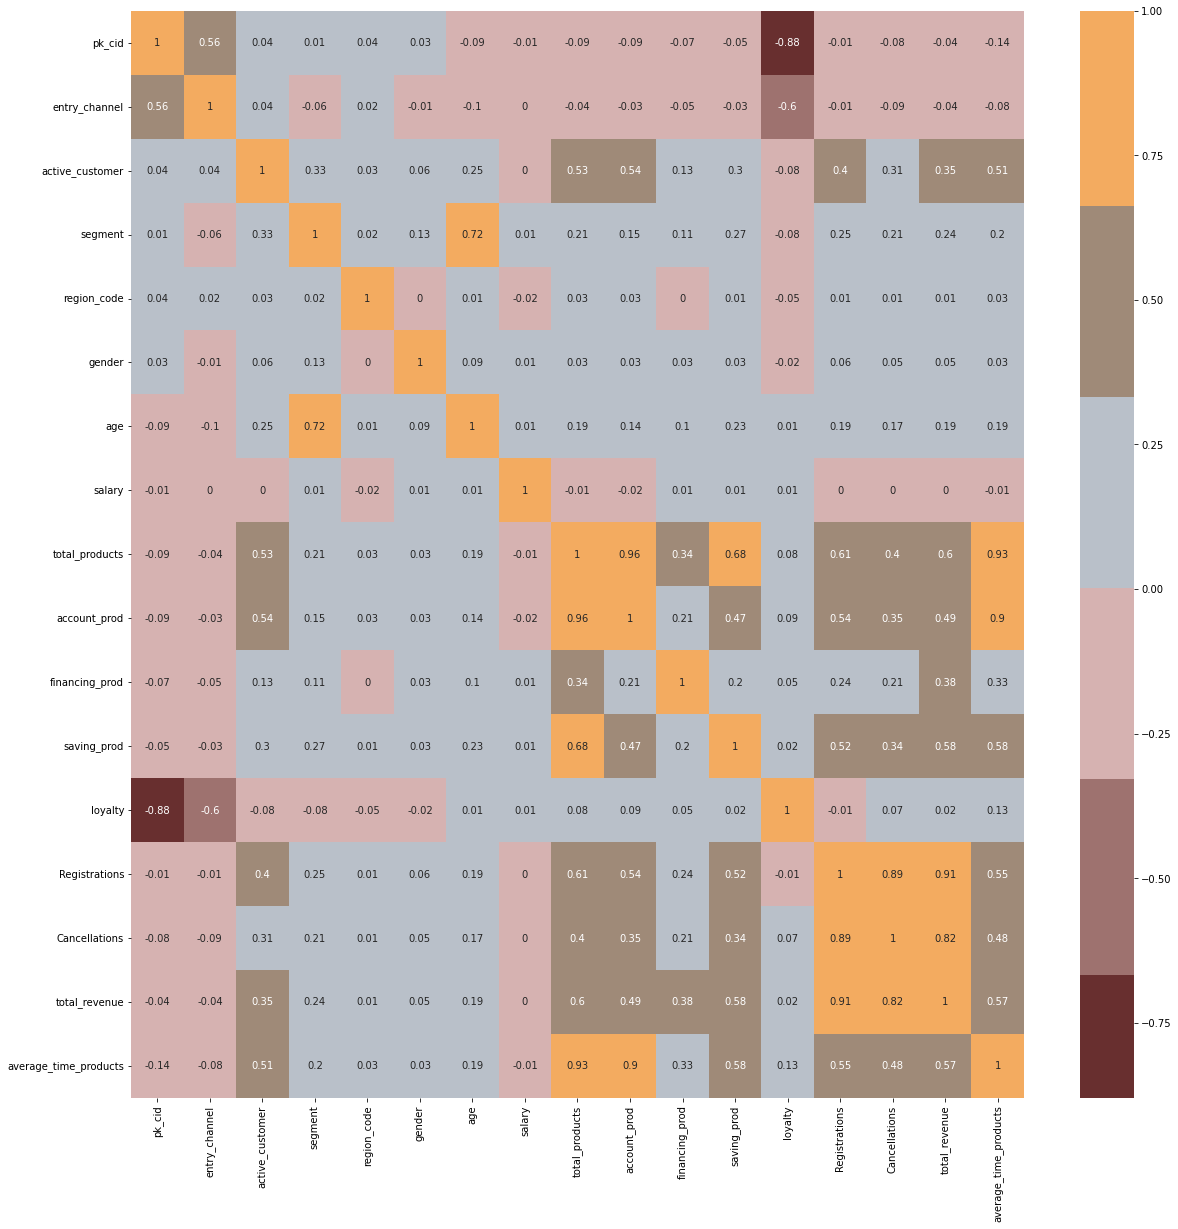

In [31]:
corrmat = df_last_partition.corr().round(2)
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

#### **4.2 Clustering using k-means**